In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xmltodict
import os
import json
import pickle
from lxml import etree


In [3]:
# mode = int(metadata['mode']) if metadata['mode'] is not None else 1
# beats_in_measure = int(metadata['beats_in_measure'])

# melody, chord = segments_parser(segments, mode, beats_in_measure)

In [4]:
from pathlib import Path

In [5]:
version = 'v7'
data_path = Path('data/midi')
version_path = data_path/version
orig_path = version_path/'midi_sources'

In [6]:
from fastai.data_block import get_files

In [7]:
h_path = orig_path/'hooktheory'

In [8]:
files = get_files(h_path, extensions=['.xml'], recurse=True); files[:10]

[PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wayne-sharpe/yu-gi-oh-theme-song/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wayne-sharpe/yu-gi-oh-theme-song/intro.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/what-a-day/kiefer/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/pre-chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/verse.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/verse.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/intro.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/freedom/chorus.xml')]

In [9]:
from src.tab_parser import *

In [10]:
from src import roman_to_symbol
from src import to_pianoroll
from collections import defaultdict
from midi_data import keyc_offset

In [11]:
def parse_file(file_path):
    content = load_data(file_path)
    root = xml_parser(content)
    metadata, version = get_metadata(root)
    segments, num_measures = get_lead_sheet(root, version)
    
    song = HSong.parse(metadata, segments)
    return song

In [12]:
import music21

### Create config file

In [13]:
# sustain=True, sep_octave=True, sus_idx=2, hit_idx=1
config_opts = dict(note_octave=4, chord_octave=3, 
              bim=4, key=0, bpm=120, freq=4, bos_idx=-1, pad_idx=-3, none_idx=-2, enc_offset=3)

# none_idx is a rest - checked by cross_entropy, pad_idx is not countd in loss

class Config(object):
    def __init__(self, d): self.__dict__ = d
        
config = Config(config_opts)

### Constants

In [14]:
MODE_TO_KEYOFFSET = {
    '1': 0,
    '2': 2,
    '3': 4,
    '4': 5,
    '5': 7,
    '6': 9,
    '7': 11
}

In [15]:
PITCH_TO_SD = {
    0: '1',
    1: '1#',
    2: '2',
    3: '2#',
    4: '3',
    5: '4',
    6: '4#',
    7: '5',
    8: '5#',
    9: '6',
    10:'6#',
    11:'7',
}

SD_TO_PITCH = {v:k for k,v in PITCH_TO_SD.items()}

### Classes

In [16]:
from dataclasses import dataclass
import dataclasses
from typing import Dict, Any, AnyStr, List, Sequence, TypeVar, Tuple, Optional, Union

In [17]:
def parse(cls, d):
    cls_keys = cls.__dataclass_fields__.keys()
    kwargs = {key:d[key] for key in cls_keys}
    return cls(**kwargs)

@dataclass
class Base:
    @classmethod
    def from_dict(cls, d):
        cls_keys = cls.__dataclass_fields__.keys()
        kwargs = {key:d[key] for key in cls_keys}
        return cls(**kwargs)
    
    @classmethod
    def parse(cls, d):
        return cls.from_dict(d)

In [18]:
@dataclass
class HMetadata(Base):
    title:str
    BPM:str='120'
    beats_in_measure:str='4'
    key:str='C'
    mode:str='1'

In [19]:
@dataclass
class HBeat(Base):
    def __init__(self, abs:float, duration:float, measure:float, rel:float, **kwargs):
        self.abs = float(abs)
        self.duration = float(duration)
        self.measure = float(measure) if measure else None
        self.rel = float(rel) if rel else None
    @classmethod
    def parse_note(cls, d):
        return cls(abs=d['start_beat_abs'], 
                   duration=d['note_length'], 
                   measure=d['start_measure'],
                   rel=d['start_beat'])
    @classmethod
    def parse_chord(cls, d):
        return cls(abs=d['start_beat_abs'], 
                   duration=d['chord_duration'], 
                   measure=d['start_measure'],
                   rel=d['start_beat'])
    
    def end_time(self):
        return self.duration + self.abs
    
    def __repr__(self):
        return f'abs={self.abs}:dur={self.duration}'
        
@dataclass
class HPitch(Base):
    def __init__(self, pitch:int, octave:int, **kwargs):
        self.pitch = pitch
        self.octave = octave
    
    def sd(self):
        return PITCH_TO_SD[self.pitch]
    
    def abs(self, base_octave:int=0):
        if self.octave is None: return self.pitch
        return self.pitch + 12 * (self.octave+base_octave)
    
    def __repr__(self):
        return f'sd={self.sd()}:oct={self.octave}'
    
    @classmethod
    def parse_abs_pitch(cls, abs_pitch):
        abs_pitch = int(abs_pitch)
        pitch = abs_pitch%12
        octave = abs_pitch//12
        return cls(pitch=pitch, octave=octave)

In [20]:
@dataclass
class HNote(Base):
    def __init__(self, beat:HBeat, pitch:HPitch, **kwargs):
        self.beat = beat
        self.pitch = pitch
        
    def to_m21(self)->music21.note.Note:
        p = self.pitch.abs(base_octave=config.note_octave)
        n = music21.note.Note(p, quarterLength=self.beat.duration)
        return n, self.beat.abs
    
    def end_time(self):
        return self.beat.end_time()
    
    def __repr__(self):
        return f'B({self.beat}) P({self.pitch})'
    
    @classmethod
    def parse(cls, d, mode, key_offset):
        parsed = roman_to_symbol.hnote_parser(d, mode, key_offset)
        pitch = HPitch.parse_abs_pitch(parsed['pitch'])
        beat = HBeat.parse_note(d)
        return cls(beat=beat, pitch=pitch)

In [21]:
def remove_embelishment(d):
    d = d.copy()
    d['sus'] = None
    d['emb'] = None
    return d

def remove_9_11_chords(d):
    d = d.copy()
    if isinstance(d.get('fb'), str) and int(d['fb'][0]) > 7: d['fb'] = '9'
    return d
    
def shift_octave(parsed):
    lowest = min(parsed['composition'])
    if lowest >= 12:
        parsed = parsed.copy()
        parsed = roman_to_symbol.chord_key_shifting(parsed, -12)
        # reset chord name
        new_s = roman_to_symbol.chord_to_string(parsed)
        parsed['symbol'] = new_s
    return parsed

@dataclass
class HChord(Base):
    def __init__(self, beat:HBeat, pitches:List[HPitch], 
                 composition:List[int]=None, symbol:str=None, quality:str=None, metadata=None, **kwargs):
        self.beat = beat
        self.pitches = pitches
        self.composition, self.symbol, self.quality = composition, symbol, quality
        self.metadata = None
        
    def end_time(self):
        return self.beat.end_time()
        
    def to_m21(self)->music21.chord.Chord:
        notes = [p.abs(base_octave=config.chord_octave) for p in self.pitches]
        c = music21.chord.Chord(notes, quarterLength=self.beat.duration)
        return c, float(self.beat.abs)
    
    def __repr__(self):
        return f'B({self.beat}) C([{self.pitches}])'# + ' Comp:' + str(self.composition)

    @classmethod
    def parse(cls, d, mode, key_offset, reset_to_base=True, remove_emb=False, remove_large=True):
        if remove_emb: d = remove_embelishment(d)
        if remove_large: remove_9_11_chords(d)
        if d.get('emb') == 'add4': d['emb'] = None
        parsed = roman_to_symbol.hchord_parser(d, mode, key_offset)
        
        # After offset, let's reset the chord to be the lowest possible offset on new scale
        if reset_to_base: parsed = shift_octave(parsed)
        parsed['composition'] = parsed['composition'].astype(int).tolist()
        
        beat = HBeat.parse_chord(d)
        pitches = [HPitch.parse_abs_pitch(p) for p in sorted(parsed['composition'])] # first pitch = base note
        
        return cls(beat=beat, pitches=pitches, metadata=parsed, **parsed)

In [22]:
def default_stream(cls=music21.stream.Score, ts='4/4', bpm=120, ks=0):
    # (AS) TODO: use config ts or metadata
    s = cls()
    s.append(music21.instrument.Piano())
    s.append(music21.meter.TimeSignature(ts))
    s.append(music21.tempo.MetronomeMark(number=bpm))
#     s.append(music21.key.KeySignature(ks))
    s.append(music21.key.Key('C'))
    return s

In [23]:
@dataclass
class HPart(Base):
    notes: List[HNote]
    chords: List[HChord]
        
    @classmethod
    def parse(cls, d, metadata):
        mode = metadata['mode'] or '1'
        key_offset = MODE_TO_KEYOFFSET.get(mode, 0)
        ns = [HNote.parse(n, mode, key_offset) for n in d.get('notes', []) if n['scale_degree'] != 'rest']
        cs = [HChord.parse(c, mode, key_offset) for c in d.get('chords', []) if c['sd'] != 'rest']
        ns = sorted(ns, key=lambda n: n.end_time())
        cs = sorted(cs, key=lambda c: c.end_time())
        return cls(notes=ns, chords=cs)
    
    def __repr__(self):
        chords = '[Chords]:\n' + '\n'.join([str(c) for c in self.chords])
        notes = '[Notes]:\n' + '\n'.join([str(n) for n in self.notes])
        return chords + '\n\n' + notes
    
    def duration(self):
        c_last = self.chords[-1].end_time() if self.chords else 0
        n_last = self.notes[-1].end_time() if self.notes else 0
        return max(c_last, n_last)
    
    def to_m21(self)->music21.stream.Stream:
        mc = music21.stream.Part()
        mn = music21.stream.Part()
        
        cm21 = [c.to_m21() for c in self.chords]
        for c,d in cm21: mc.insert(d,c)
            
        nm21 = [n.to_m21() for n in self.notes]
        for n,d in nm21: mn.insert(d,n)
        return mn, mc
        
    def min_pitch(self):
        return min([n.pitch for n in self.notes])

In [24]:
@dataclass
class HSong(Base):
    metadata: HMetadata
    parts: List[HPart]
    
    @classmethod
    def parse(cls, metadata, segments):
        m = HMetadata.parse(metadata)
        ps = [HPart.parse(s, metadata) for s in segments]
        return cls(metadata=m, parts=ps)
    
    def duration(self):
        return sum(p.duration() for p in self.parts)
    
    
    def __repr__(self):
        parts = ''
        for idx,p in enumerate(self.parts):
            parts += f'Part[{idx}]:\n' + str(p) + '\n\n'
        return parts + '\n\n' + str(self.metadata)
    
    def to_stream(self):
        s = default_stream()
        pc = music21.stream.Part()
        pn = music21.stream.Part()
        
        for p in self.parts:
            mn, mc = p.to_m21()
            pn.append(mn)
            pc.append(mc)
            
        s.insert(0, pn)
        s.insert(0, pc)

#         s.flat.makeNotation(inPlace=True)
        s = s.transpose(0) # hack to get accidentals right. Above method does not work
        # music21 stream
        return s

In [25]:
from src import roman_to_symbol
from src import to_pianoroll
from collections import defaultdict
from midi_data import keyc_offset

In [26]:
import numpy as np
from collections import Counter, defaultdict

In [27]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [28]:
from src.roman_to_symbol import *

## Testing xml to hsong

In [29]:
# Loading from specific file
# keywords = ['get-lucky', 'daft-punk', 'pre-chorus']
# keywords = ['skrillex', 'scary']
# keywords = ['idina', 'verse', 'let']
keywords = ['idina', 'intro', 'let']
# keywords = ['game-of-thrones', 'intro', 'ramin']
# keywords = ['kiss-from-a-rose', 'seal']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v7/midi_sources/hooktheory/xml/i/idina-menzel/let-it-go/intro.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/i/idina-menzel/let-it-go/intro-and-verse.xml')]

In [30]:
file_path = search[0]

In [31]:
content = load_data(file_path)
root = xml_parser(content)
metadata, version = get_metadata(root)
segments, num_measures = get_lead_sheet(root, version)

In [32]:
song = HSong.parse(metadata, segments); song

Part[0]:
[Chords]:
B(abs=0.0:dur=4.0) C([[sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=4.0:dur=4.0) C([[sd=4:oct=0, sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=8.0:dur=4.0) C([[sd=5:oct=0, sd=6:oct=0, sd=2:oct=1]])
B(abs=12.0:dur=2.0) C([[sd=2:oct=0, sd=5:oct=0, sd=6:oct=0]])
B(abs=14.0:dur=2.0) C([[sd=2:oct=0, sd=4:oct=0, sd=6:oct=0]])
B(abs=16.0:dur=4.0) C([[sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=20.0:dur=4.0) C([[sd=4:oct=0, sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=24.0:dur=4.0) C([[sd=5:oct=0, sd=6:oct=0, sd=2:oct=1]])
B(abs=28.0:dur=2.0) C([[sd=2:oct=0, sd=5:oct=0, sd=6:oct=0]])
B(abs=30.0:dur=2.0) C([[sd=2:oct=0, sd=4#:oct=0, sd=6:oct=0]])

[Notes]:
B(abs=0.0:dur=0.5) P(sd=7:oct=1)
B(abs=0.5:dur=0.5) P(sd=1:oct=2)
B(abs=1.0:dur=0.5) P(sd=3:oct=1)
B(abs=1.5:dur=1.0) P(sd=7:oct=1)
B(abs=2.5:dur=0.5) P(sd=1:oct=2)
B(abs=4.0:dur=0.5) P(sd=7:oct=1)
B(abs=4.5:dur=0.5) P(sd=1:oct=2)
B(abs=5.0:dur=0.5) P(sd=3:oct=1)
B(abs=5.5:dur=1.0) P(sd=1:oct=2)
B(abs=6.5:dur=1.0) P(sd=7:oct=1)

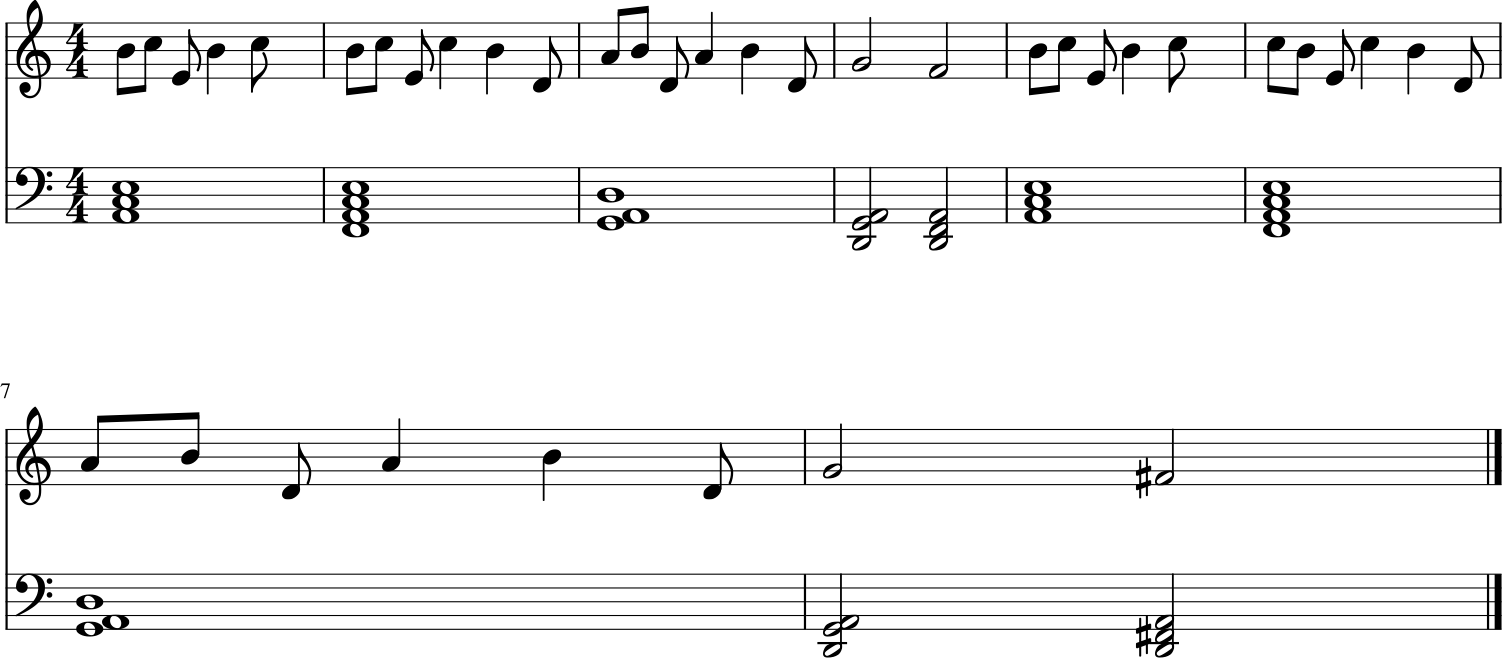

In [33]:
stream = song.to_stream()
# stream.show('midi')
stream.show()

In [34]:
ENC_IDXS = [0,1,2,3,4,5,6,7,8,9]
iN,iNO,iND,iC1,iC2,iC3,iC4,iCD,iB,iM = ENC_IDXS
CIDXS = [iC1,iC2,iC3,iC4]
NIDX_ALL = [iN,iNO,iND]
BIDX_ALL = [iB,iM]

def enc_part(part):
#     '(pitch x octave x sustain) x (chord_sd x base x suspend, sustain) x (bar_position x beat_pos)'
    '(pitch x octave x dur) x (c1,c2,c3,c4,dur) x (bar_position x beat_pos)'
    max_len = int(part.duration()*config.freq)
    sequence = np.full((max_len, len(ENC_IDXS)), fill_value=config.pad_idx, dtype=int)
    sequence[:,[iN,iC1]] = config.none_idx
    
    # beat_pos
    bim = config.bim # beats_in_measure = 4
    sequence[:, iB] = np.tile(np.arange(bim).repeat(config.freq), int(part.duration())//bim+1)[:sequence.shape[0]]
    # bar_pos
    sequence[:, iM] = np.arange(part.duration()//bim+1).repeat(config.freq*bim)[:sequence.shape[0]]
    
    def enc_beat(beat):
        start = round(beat.abs * config.freq, 6) # float conversion error
        duration = round(beat.duration * config.freq, 6)
        end = start+duration
        
        assert(start.is_integer() and duration.is_integer())
        return start, end, duration
    
    for n in part.notes:
        start, end, duration = enc_beat(n.beat)
        sequence[int(start),NIDX_ALL] = n.pitch.pitch, n.pitch.octave, duration
#         sequence[int(start),0:2] = n.beat.rel-1, n.beat.measure-1
        
    for c in part.chords:
        start, end, duration = enc_beat(c.beat)
        for idx, p in zip(CIDXS,c.pitches):
            sequence[int(start),idx] = p.pitch
        sequence[int(start),iCD] = duration
#         sequence[int(start),2:4] = c.beat.rel-1, c.beat.measure-1
    return sequence

In [35]:
def enc_song(song):
    eps = [enc_part(p) for p in song.parts]
    cat = np.concatenate(eps)
    bos_row = np.full((1, cat.shape[-1]), fill_value=config.pad_idx)
    bos_row[:,[iN,iC1]] = config.bos_idx
    enc_all = np.concatenate((bos_row, cat))
    return enc_all + config.enc_offset

### NOTE: need to figure out if measure should be relative to individual parts or the whole song

In [36]:
def dec_beat(duration, beat_abs, ts):
    if (ts.shape[0] == len(ENC_IDXS)):
        rel,measure = ts[BIDX_ALL]+1 # +1 as hook is offset by 1
    else:
        rel,measure = None, None 
    return HBeat(abs=beat_abs/config.freq, duration=duration/config.freq, 
                 rel=rel, measure=measure)
    
def dec_note(ts, beat_abs):
    p,o,dur = ts[NIDX_ALL]
    
    beat = dec_beat(dur, beat_abs, ts)
    pitch = HPitch(octave=o, pitch=p)
    note = HNote(beat=beat, pitch=pitch)
    return note

def is_padding(val): 
    return val < 0
#     return val in [config.pad_idx, config.bos_idx, config.none_idx]

def dec_chord(ts, beat_abs):
    
    beat = dec_beat(ts[iCD], beat_abs, ts)
    
    octave = 0
    pitches = []
    pvals = ts[CIDXS]
    for idx,p in enumerate(pvals):
        if (idx > 0) and (p < pvals[idx-1]): 
            octave += 1
        if is_padding(p): continue
        pitches.append(HPitch(pitch=int(p), octave=octave))
    chord = HChord(pitches=pitches, beat=beat)
    return chord

def dec_part(part):
    '(pitch x octave x dur) x (c1,c2,c3,c4,dur) x (bar_position x beat_pos)'
    notes = [dec_note(ts,idx) for idx,ts in enumerate(part) if not is_padding(ts[iN])]
    chords = [dec_chord(ts,idx) for idx,ts in enumerate(part) if not is_padding(ts[iC1])]
    
    return HPart(notes=notes, chords=chords)

def dec_arr(arr):
    arr = arr-config.enc_offset
    if any(arr[0] == config.bos_idx):
        arr = arr[1:]
    dp = dec_part(arr)
    return HSong(parts=[dp], metadata=HMetadata('decoded'))

In [37]:
encs = enc_song(song)

In [38]:
dec_song = dec_arr(encs); dec_song

Part[0]:
[Chords]:
B(abs=0.0:dur=4.0) C([[sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=4.0:dur=4.0) C([[sd=4:oct=0, sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=8.0:dur=4.0) C([[sd=5:oct=0, sd=6:oct=0, sd=2:oct=1]])
B(abs=12.0:dur=2.0) C([[sd=2:oct=0, sd=5:oct=0, sd=6:oct=0]])
B(abs=14.0:dur=2.0) C([[sd=2:oct=0, sd=4:oct=0, sd=6:oct=0]])
B(abs=16.0:dur=4.0) C([[sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=20.0:dur=4.0) C([[sd=4:oct=0, sd=6:oct=0, sd=1:oct=1, sd=3:oct=1]])
B(abs=24.0:dur=4.0) C([[sd=5:oct=0, sd=6:oct=0, sd=2:oct=1]])
B(abs=28.0:dur=2.0) C([[sd=2:oct=0, sd=5:oct=0, sd=6:oct=0]])
B(abs=30.0:dur=2.0) C([[sd=2:oct=0, sd=4#:oct=0, sd=6:oct=0]])

[Notes]:
B(abs=0.0:dur=0.5) P(sd=7:oct=1)
B(abs=0.5:dur=0.5) P(sd=1:oct=2)
B(abs=1.0:dur=0.5) P(sd=3:oct=1)
B(abs=1.5:dur=1.0) P(sd=7:oct=1)
B(abs=2.5:dur=0.5) P(sd=1:oct=2)
B(abs=4.0:dur=0.5) P(sd=7:oct=1)
B(abs=4.5:dur=0.5) P(sd=1:oct=2)
B(abs=5.0:dur=0.5) P(sd=3:oct=1)
B(abs=5.5:dur=1.0) P(sd=1:oct=2)
B(abs=6.5:dur=1.0) P(sd=7:oct=1)

In [39]:
dec_stream = dec_song.to_stream()

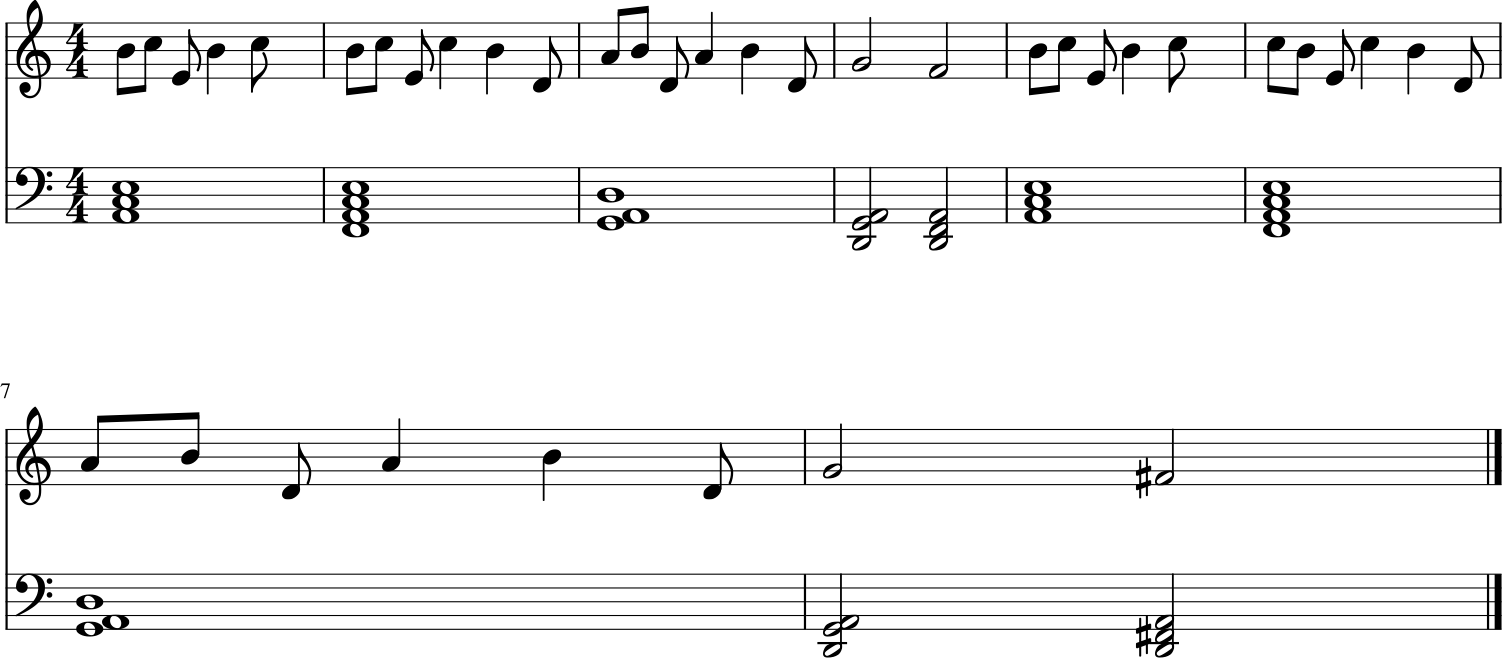

In [40]:
dec_stream.show()

In [41]:
dec_stream.show('midi')

### Encode all songs

In [42]:
from fastai.data_block import get_files

In [43]:
out_path = version_path/'midi_encode/np/hook_dur/'
out_dir = out_path/'hooktheory'
h_path = orig_path/'hooktheory/xml'

In [44]:
files = get_files(h_path, extensions=['.xml'], recurse=True); files[:10]

[PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wayne-sharpe/yu-gi-oh-theme-song/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wayne-sharpe/yu-gi-oh-theme-song/intro.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/what-a-day/kiefer/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/pre-chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/verse.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/whiteflame/senbonzakura/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/verse.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/chorus.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/last-christmas/intro.xml'),
 PosixPath('data/midi/v7/midi_sources/hooktheory/xml/w/wham/freedom/chorus.xml')]

In [45]:
metadata

{'title': 'Let It Go',
 'beats_in_measure': '4',
 'BPM': '137',
 'key': 'F',
 'YouTubeID': 'moSFlvxnbgk',
 'mode': '6',
 'duration': '16.81'}

In [46]:
def parse_file(file_path):
    content = load_data(file_path)
    try: 
        root = xml_parser(content)
        metadata, version = get_metadata(root)
        segments, num_measures = get_lead_sheet(root, version)
    except Exception as e: 
        print('XML parse exception:', e)
        return None
    
    song = HSong.parse(metadata, segments)
    return song

In [47]:
def process_file(file):
    out_file = file.relative_to(h_path).with_suffix('.npy')
    out_path = out_dir/out_file
    if out_path.exists(): return out_file, out_file
    song = parse_file(file)
    if song is None or int(song.metadata.beats_in_measure) != 4: return out_file, None
    out_path.parent.mkdir(parents=True, exist_ok=True)
    npenc = enc_song(song)
    np.save(out_path, npenc)
    return out_file, out_file

In [48]:
process_file(file_path)

(PosixPath('i/idina-menzel/let-it-go/intro.npy'),
 PosixPath('i/idina-menzel/let-it-go/intro.npy'))

In [49]:
from data_sources import process_parallel

In [50]:
# subset = files
# for f in subset:
#     process_file(f)

In [51]:
subset = files
encoded_files = process_parallel(process_file, subset, total=len(subset))

#5
#5
XML parse exception: 'NoneType' object has no attribute 'text'
XML parse exception: Unicode strings with encoding declaration are not supported. Please use bytes input or XML fragments without declaration.
XML parse exception: Unicode strings with encoding declaration are not supported. Please use bytes input or XML fragments without declaration.
XML parse exception: Unicode strings with encoding declaration are not supported. Please use bytes input or XML fragments without declaration.
XML parse exception: Unicode strings with encoding declaration are not supported. Please use bytes input or XML fragments without declaration.
#5
#5
#5
#5
#5
#5
XML parse exception: Unicode strings with encoding declaration are not supported. Please use bytes input or XML fragments without declaration.
XML parse exception: Unicode strings with encoding declaration are not supported. Please use bytes input or XML fragments without declaration.
XML parse exception: Unicode strings with encoding decl

### Databunch

In [52]:
from fastai_data import *
from fastai.text import *

In [53]:
np_files = get_files(out_dir, extensions=['.npy'], recurse=True); np_files[:10]

[PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/wayne-sharpe/yu-gi-oh-theme-song/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/what-a-day/kiefer/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/whiteflame/senbonzakura/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/whiteflame/senbonzakura/pre-chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/whiteflame/senbonzakura/verse.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/wham/last-christmas/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/wham/last-christmas/intro.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/wham/last-christmas/verse.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/wham/freedom/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_dur/hooktheory/w/we-lost-the-sea/bogatyri/intro.npy')]

In [54]:
out_path

PosixPath('data/midi/v7/midi_encode/np/hook_dur')

In [55]:
def create_databunch(files, cache_name, batch_size=32, load_cached=False):
    if load_cached and (out_path/f'{cache_name}/train_ids.npy').exists():
        data = LMNPDataBunch.load(out_path, bs=batch_size, cache_name=cache_name)
    else:
        ps = [OpenNPFileProcessor()]

        data = (ItemList(items=files, path=out_path, processor=ps)
                .random_split_by_pct(0.01, seed=6)
                .label_const(label_cls=LMLabelList))
        data.x._bunch = LMNPDataBunch
        data = data.databunch(bs=batch_size)
        data.save(cache_name)
    return data

In [56]:
all_data = create_databunch(np_files, cache_name='tmp/all', load_cached=True)

In [57]:
all_data

LMNPDataBunch;

Train: LabelList (17985 items)
x: ItemList
[[ 2  0  0  2  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0  3  3]
 [10  2  4  1  0  0  0  0  3  3]
 [ 9  2  4  1  0  0  0  0  3  3]
 [12  1  4  1  0  0  0  0  3  3]
 [ 8  2  4  1  0  0  0  0  4  3]
 [ 7  2  4  1  0  0  0  0  4  3]
 [12  1  4  1  0  0  0  0  4  3]
 [ 8  2  4  1  0  0  0  0  4  3]
 [ 7  2  4  1  0  0  0  0  5  3]
 ...
 [ 1  0  0  1  0  0  0  0  4 10]
 [ 1  0  0  1  0  0  0  0  4 10]
 [ 1  0  0  1  0  0  0  0  5 10]
 [ 1  0  0  1  0  0  0  0  5 10]
 [ 1  0  0  1  0  0  0  0  5 10]
 [ 1  0  0  1  0  0  0  0  5 10]
 [ 1  0  0  1  0  0  0  0  6 10]
 [ 1  0  0  1  0  0  0  0  6 10]
 [ 1  0  0  1  0  0  0  0  6 10]
 [ 1  0  0  1  0  0  0  0  6 10]],[[ 2  0  0  2  0  0  0  0  0  0]
 [10  4  4 10 14  5  8  9  3  3]
 [ 7  4  4  1  0  0  0  0  3  3]
 [ 3  4  5  1  0  0  0  0  3  3]
 [ 1  0  0  1  0  0  0  0  3  3]
 [ 5  4  5  1  0  0  0  0  4  3]
 [ 1  0  0  1  0  0  0  0  4  3]
 [ 1  0  0 12 14  7 10 13  4  3]
 [ 5  4  5 

In [58]:
ob = next(iter(all_data.train_dl))

In [59]:
ob[0].shape

torch.Size([32, 70, 10])

In [60]:
ob[0][0][:16], ob[1][0][:16]

(tensor([[ 1,  0,  0, 10, 12,  3,  7,  7,  5,  7],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  5,  7],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  5,  7],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  5,  7],
         [ 1,  0,  0, 12, 14,  5,  9,  7,  6,  7],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  6,  7],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  6,  7],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  6,  7],
         [ 1,  0,  0,  3,  6, 10,  0, 19,  3,  8],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  3,  8],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  3,  8],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  3,  8],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  4,  8],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  4,  8],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  4,  8],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  4,  8]]),
 tensor([[ 1,  0,  0, 12, 14,  5,  9,  7,  6,  7],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  6,  7],
         [ 1,  0,  0,  1,  0,  0,  0,  0,  6,  7],
         [ 1,  0,  0,  1,  0,